In [3]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from py_esdc.data import window_xy, get_xy_indices
from kernellib.dependence import HSIC, RHSIC

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Extract ESDC Data

In [4]:
!ls /media/disk/databases/BACI-CABLAB/low_res_data/


aerosol_optical_thickness_550  latent_energy
aerosol_optical_thickness_555  net_ecosystem_exchange
aerosol_optical_thickness_659  open_water_evaporation
aerosol_optical_thickness_865  ozone
air_temperature_2m	       potential_evaporation
bare_soil_evaporation	       precipitation
black_sky_albedo	       root_moisture
burnt_area		       sensible_heat
c_emissions		       snow_sublimation
country_mask		       snow_water_equivalent
evaporation		       soil_moisture
evaporative_stress	       surface_moisture
fractional_snow_cover	       terrestrial_ecosystem_respiration
gross_primary_productivity     transpiration
interception_loss	       water_mask
land_surface_temperature       water_vapour


In [5]:
!ls /media/disk/databases/BACI-CABLAB/low_res_data/water_mask

2001_water_mask.nc


In [128]:
# variables for the experiment
variables = [
    'gross_primary_productivity',
#     'land_surface_temperature',
#     'air_temperature_2m',
#     'transpiration',
#     'evaporation',
    'soil_moisture'
]

year = '2011'
start_time = year
end_time = year
subsection = 'europe'
data_path = '/media/disk/databases/BACI-CABLAB/low_res_data/'
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'
figures_path = '/home/emmanuel/projects/2019_sakame/reports/figures/dependence/'

In [129]:


# Initialize data class
esdc_data = ESDCData(
    variables=variables,
    time_frame=[start_time, end_time],
    subsection=subsection,
    minicube_path=minicube_path
)

# Extract data
data = esdc_data.extract_datacube()

In [130]:
data

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 144, lon: 312, time: 46)
Coordinates:
  * lon                         (lon) float32 -17.875 -17.625 ... 59.625 59.875
  * lat                         (lat) float32 71.375 71.125 ... 35.875 35.625
  * time                        (time) datetime64[ns] 2011-01-05 ... 2011-12-31
    mask                        (lat, lon) float32 2.0 2.0 2.0 ... 1.0 1.0 1.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<shape=(46, 2), chunksize=(46, 2)>
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(46, 312, 2), chunksize=(46, 312, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(46, 144, 2), chunksize=(46, 144, 2)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(46, 144, 312), chunksize=(46, 144, 312)>
    soil_moisture               (time, lat, lon) float32 dask.array<shape=(46, 14

In [131]:
(data.gross_primary_productivity)

<xarray.DataArray 'gross_primary_productivity' (time: 46, lat: 144, lon: 312)>
dask.array<shape=(46, 144, 312), dtype=float32, chunksize=(46, 144, 312)>
Coordinates:
  * lon      (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat      (lat) float32 71.375 71.125 70.875 70.625 ... 36.125 35.875 35.625
  * time     (time) datetime64[ns] 2011-01-05 2011-01-13 ... 2011-12-31
    mask     (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    url:            http://www.fluxcom.org/
    standard_name:  gross_primary_productivity_of_carbon
    units:          gC m-2 day-1
    long_name:      Gross Primary Productivity
    source_name:    GPPall
    references:     Tramontana, Gianluca, et al. "Predicting carbon dioxide a...

In [132]:
(data.soil_moisture)

<xarray.DataArray 'soil_moisture' (time: 46, lat: 144, lon: 312)>
dask.array<shape=(46, 144, 312), dtype=float32, chunksize=(46, 144, 312)>
Coordinates:
  * lon      (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat      (lat) float32 71.375 71.125 70.875 70.625 ... 36.125 35.875 35.625
  * time     (time) datetime64[ns] 2011-01-05 2011-01-13 ... 2011-12-31
    mask     (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    url:            http://www.esa-soilmoisture-cci.org
    source_name:    SoilMoisture
    long_name:      soil moisture
    comment:        Soil moisture based on the SOilmoisture CCI project
    references:     Liu, Y.Y., Parinussa, R.M., Dorigo, W.A., De Jeu, R.A.M.,...
    standard_name:  soil_moisture_content
    units:          m3

In [133]:
# Extract summertime months
subset = data.sel(time=slice(f'{year}-06', f'{year}-08'))

# Take GPP and land surface temperature
gpp_data = subset.gross_primary_productivity.where(subset.mask==1)
sm_data = subset.soil_moisture.where(subset.mask==1)

n_time, n_lat, n_lon = gpp_data.shape

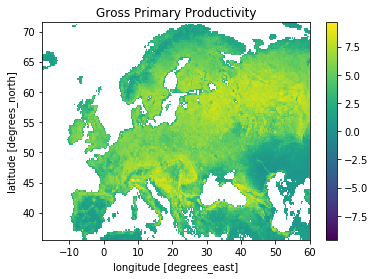

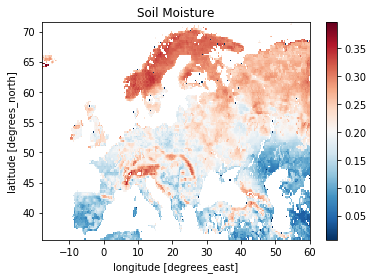

In [134]:
fig, ax = plt.subplots()

gpp_data.mean(dim='time', skipna=False).plot.imshow(ax=ax, cmap='viridis', robust=False)
ax.set_title('Gross Primary Productivity')
plt.show()

fig, ax = plt.subplots()

sm_data.mean(dim='time', skipna=False).plot.imshow(ax=ax, cmap='RdBu_r', robust=False)
ax.set_title('Soil Moisture')
plt.show()

### Conversion: Pandas DataFrame & Xarray Dataset

In [135]:
# convert xarray to df
def create_df(xr_array, variable='gross_primary_productivity'):
    """Function to convert an xarray into a dataframe.
    This also preserves the lat and lon coordinates."""
    # Subset
    xr_df = subset.where(subset.mask==1).mean(dim='time', skipna=True)[variable].to_dataframe(variable).dropna()
    # drop mask
    xr_df = xr_df.drop('mask', 1)
    
    # Remove duplicates
    xr_df = xr_df.reset_index().pivot_table(
        index=range(xr_df.shape[0]),
        values=[variable, 'lat', 'lon']
    ).drop_duplicates()
    
    return xr_df

# Convert df to xarray
def create_xarray(xr_df, variable='gross_primary_productivity'):
    
    xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
    return xr_df.to_xarray()

#### Convert XARRAY to DATAFRAME

In [136]:
variable = 'gross_primary_productivity'

gpp_df = create_df(subset, variable)

gpp_df.head()

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,gross_primary_productivity,lat,lon
0,2.173877,71.375,51.875
1,2.111698,71.375,52.125
2,1.618549,71.375,52.375
3,1.455148,71.375,52.625
4,1.280748,71.375,52.875


#### Convert DATAFRAME to XARRAY

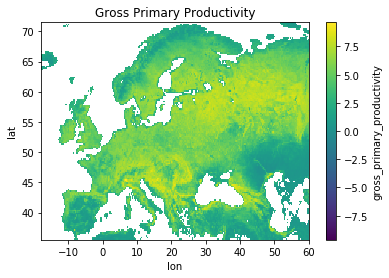

In [137]:
gpp_xr = create_xarray(gpp_df, variable)

fig, ax = plt.subplots()

gpp_xr[variable].plot.imshow(ax=ax, cmap='viridis', robust=False)
ax.set_title('Gross Primary Productivity')
plt.show()

In [138]:
gpp_df = create_df(subset, variable='gross_primary_productivity')
sm_df = create_df(subset, variable='soil_moisture')

var_df = gpp_df.merge(sm_df)
var_df = var_df.dropna()



/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [139]:
Y = var_df['soil_moisture'].values
X = var_df['gross_primary_productivity'].values
lat = var_df['lat']
lon = var_df['lon']

### Extract Data with time as dimension

In [140]:
def get_time_df(xarray, var='gross_primary_productivity'):
    
    # convert to numpy array (Spatial x Time)
    xr_df = subset[var].where(subset.mask==1).to_dataframe(var).dropna()
    
    # drop max
    xr_dr = xr_df.drop('mask', 1)
    
    # Remove duplicates
    xr_df = xr_df.unstack(level=0)
    xr_df = xr_df.reset_index().pivot_table(index=range(xr_df.shape[0]), values=[var, 'lat', 'lon'],)
    
    return xr_df

In [141]:
gpp_df = get_time_df(subset, var='gross_primary_productivity')
lst_df = get_time_df(subset, var='soil_moisture')

var_df = gpp_df.merge(lst_df)
var_df = var_df.dropna()


In [142]:
Y = var_df['soil_moisture'].values
X = var_df['gross_primary_productivity'].values
lat = var_df['lat']
lon = var_df['lon']


In [143]:
X.shape

(23090, 11)

### Train/Test Data

In [144]:
derX, derY = dict(), dict()
mod_sens, ang_sens = dict(), dict()

In [145]:
n_sub_samples = 10000
X_sub, _, Y_sub, _ = train_test_split(X, Y, train_size=n_sub_samples, random_state=123)
lat_sub, _, lon_sub, _ = train_test_split(lat, lon, train_size=n_sub_samples, random_state=123)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


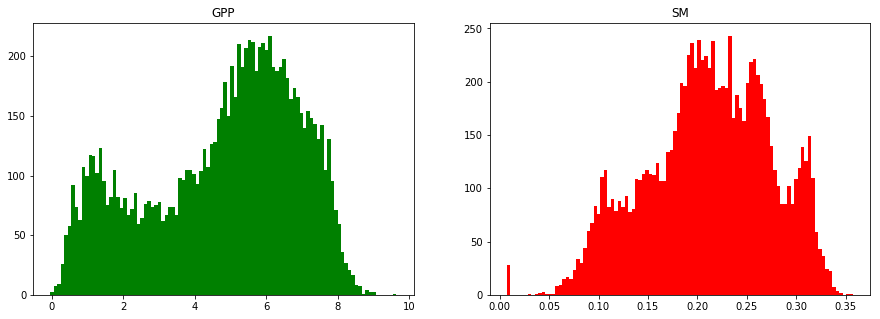

In [146]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

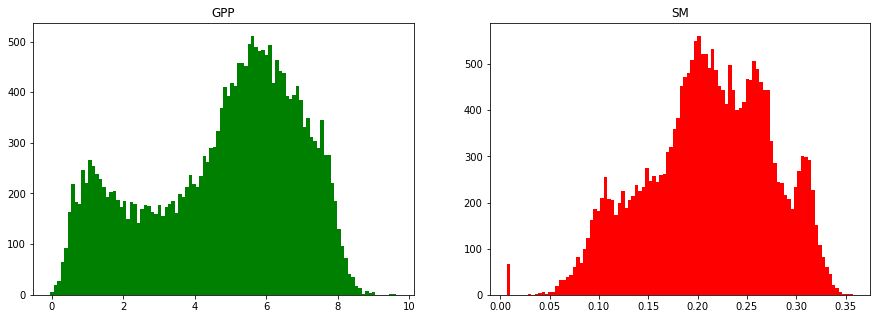

In [147]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

# HSIC (Linear Kernel)

In [148]:
%%time

lhsic_model = HSIC(kernel='lin', random_state=1234)

# hsic_model.fit(X_sub, Y_sub);

lhsic_model.fit(X_sub, Y_sub);

CPU times: user 2min 28s, sys: 20.4 s, total: 2min 48s
Wall time: 7.95 s


In [149]:
print(f"HSIC: {lhsic_model.hsic_value:.4f}")

HSIC: 0.4995


In [150]:
%%time
derX['lhsic'], derY['lhsic'] = lhsic_model.derivative()

CPU times: user 2min 21s, sys: 16 s, total: 2min 37s
Wall time: 7.01 s


In [151]:
print(derX['lhsic'].shape)

(10000, 11)


In [152]:
%%time

mod_sens['lhsic'] = np.sqrt(np.abs(derX['lhsic']).mean(axis=1)**2 + np.abs(derY['lhsic']).mean(axis=1)**2)

ang_sens['lhsic'] = (180 / np.pi) * np.arctan2(derY['lhsic'].mean(axis=1), derX['lhsic'].mean(axis=1))

CPU times: user 45 µs, sys: 60.6 ms, total: 60.7 ms
Wall time: 2.37 ms


In [153]:
print(ang_sens['lhsic'].min())

-178.75718277286228


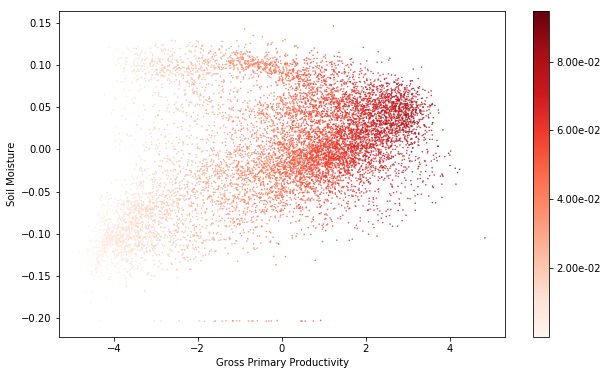

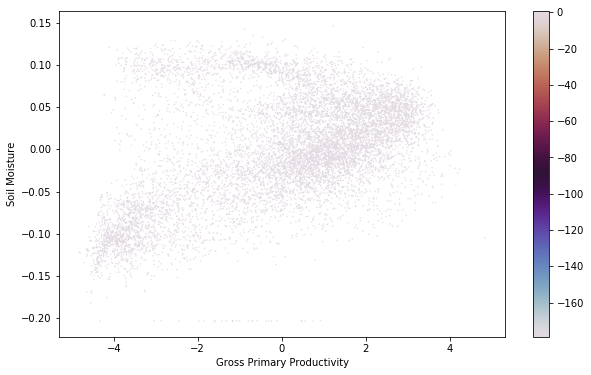

In [154]:
fig, ax = plt.subplots(figsize=(10, 6))

p = ax.scatter(X_sub.mean(axis=1), Y_sub.mean(axis=1), c=mod_sens['lhsic'], cmap=plt.cm.get_cmap('Reds'), s=0.2)
plt.colorbar(p, label='', format='%.2e')
ax.set_xlabel('Gross Primary Productivity')
ax.set_ylabel("Soil Moisture")
save_plt_name = f'lhsic_scatter_mod_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))

p = ax.scatter(X_sub.mean(axis=1), Y_sub.mean(axis=1), c=ang_sens['lhsic'], cmap=plt.cm.get_cmap('twilight'), s=0.2)
plt.colorbar(p)
ax.set_xlabel('Gross Primary Productivity')
ax.set_ylabel("Soil Moisture")
save_plt_name = f'lhsic_scatter_angle_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()

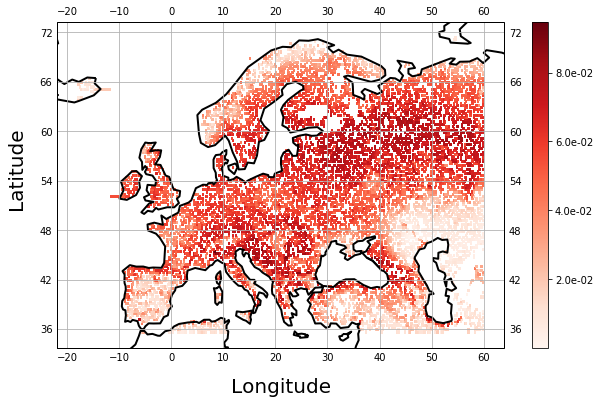

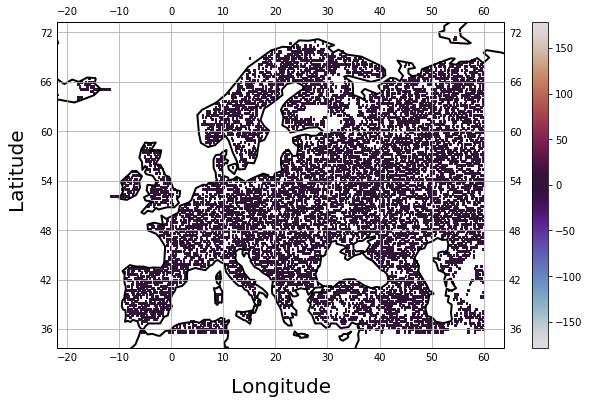

In [156]:
vis_df = pd.DataFrame({
    'lat': lat_sub,
    'lon': lon_sub,
    'sens': mod_sens['lhsic'],
})


vis_xr = create_xarray(vis_df, variable='sens')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
p = vis_xr['sens'].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='Reds', robust=False,
    cbar_kwargs={'label': '', 
                 'format': '%.1e'}
)

ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
save_plt_name = f'lhsic_mod_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()


vis_df = pd.DataFrame({
    'lat': lat_sub,
    'lon': lon_sub,
    'sens': ang_sens['lhsic'],
})

# def create_xarray(xr_df, variable='gross_primary_productivity'):
    
#     xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
#     return xr_df.to_xarray()

vis_xr = create_xarray(vis_df, variable='sens')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

p = vis_xr['sens'].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='twilight', robust=False,
    cbar_kwargs={'label': ''}
)

ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
save_plt_name = f'lhsic_angle_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()

### HSIC

In [157]:
%%time

hsic_model = HSIC(kernel='rbf', random_state=1234, sub_sample=10000)

# hsic_model.fit(X_sub, Y_sub);

hsic_model.fit(X_sub, Y_sub);

CPU times: user 2min 26s, sys: 31.1 s, total: 2min 57s
Wall time: 9.72 s


In [158]:
print(f"HSIC: {hsic_model.hsic_value:.4f}")

HSIC: 0.0212


#### Derivative HSIC

In [159]:
%%time
derX['hsic'], derY['hsic'] = hsic_model.derivative()

CPU times: user 4min 58s, sys: 20.7 s, total: 5min 19s
Wall time: 30.8 s


#### Sensitivity

In [160]:
%%time

mod_sens['hsic'] = np.sqrt(np.abs(derX['hsic']).mean(axis=1)**2 + np.abs(derY['hsic']).mean(axis=1)**2)

ang_sens['hsic'] = (180 / np.pi) * np.arctan2( derY['hsic'].mean(axis=1), derX['hsic'].mean(axis=1))

CPU times: user 1.45 ms, sys: 2.61 ms, total: 4.06 ms
Wall time: 3.23 ms


#### Visualization

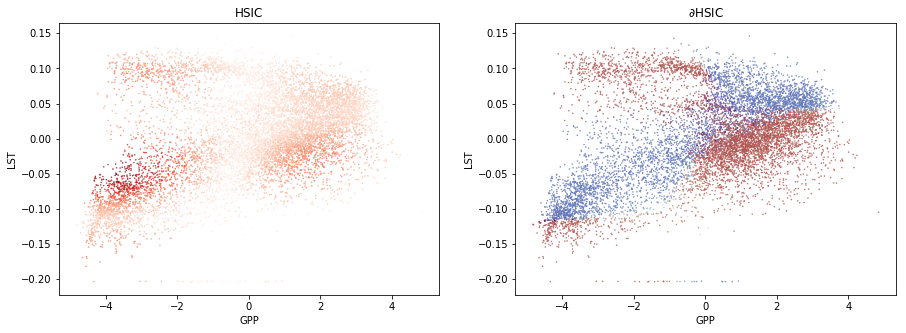

In [161]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].scatter(X_sub.mean(axis=1), Y_sub.mean(axis=1), c=mod_sens['hsic'], cmap=plt.cm.get_cmap('Reds'), s=0.2)
# ax[0].scatter(X_sub.mean(axis=1), Y_sub.mean(axis=1), c=mod_sens, cmap=plt.cm.get_cmap('RdBu'), s=0.2)
ax[0].set_xlabel('GPP')
ax[0].set_ylabel("LST")
ax[0].set_title('HSIC')

# ax[1].scatter(X_sub.mean(axis=1), Y_sub.mean(axis=1), c=ang_sens, cmap=plt.cm.get_cmap('twilight'), s=0.2)
ax[1].scatter(X_sub.mean(axis=1), Y_sub.mean(axis=1), c=ang_sens['hsic'], cmap=plt.cm.get_cmap('twilight'), s=0.2)

ax[1].set_xlabel('GPP')
ax[1].set_ylabel("LST")
ax[1].set_title(r'$\partial$HSIC')
plt.show()

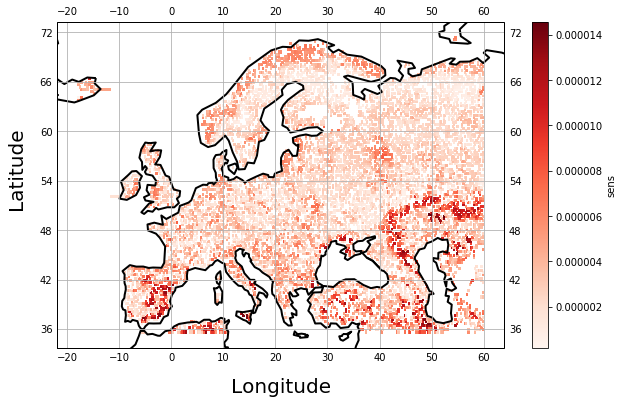

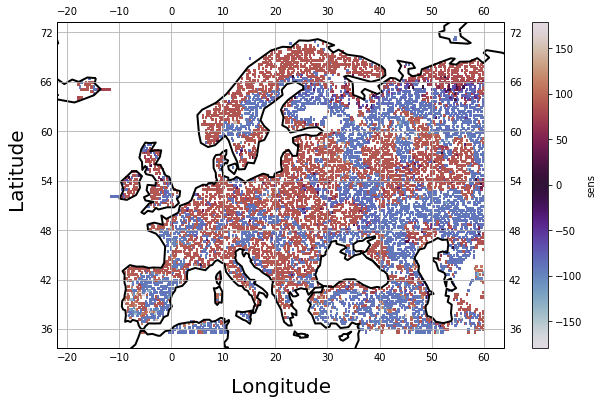

In [162]:
vis_df = pd.DataFrame({
    'lat': lat_sub,
    'lon': lon_sub,
    'sens': mod_sens['hsic'],
})

vis_xr = create_xarray(vis_df, variable='sens')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
p = vis_xr['sens'].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='Reds', robust=False
)

ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
save_plt_name = f'hsic_mod_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()


vis_df = pd.DataFrame({
    'lat': lat_sub,
    'lon': lon_sub,
    'sens': ang_sens['hsic'],
})

# def create_xarray(xr_df, variable='gross_primary_productivity'):
    
#     xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
#     return xr_df.to_xarray()

vis_xr = create_xarray(vis_df, variable='sens')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

p = vis_xr['sens'].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='twilight', robust=False
)

ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
save_plt_name = f'hsic_angle_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()

## RHSIC

In [163]:
%%time

rhsic_model = RHSIC(kernel_approx='rff', n_features=2000, random_state=1234, sub_sample=10000)

rhsic_model.fit(X, Y);

CPU times: user 51.3 s, sys: 35.5 s, total: 1min 26s
Wall time: 21.5 s


In [164]:
print(f"RHSIC: {rhsic_model.hsic_value:.4f}")

RHSIC: 0.0218


### Derivative

In [165]:
%%time
derX['rhsic'], derY['rhsic'] = rhsic_model.derivative()

CPU times: user 15min 23s, sys: 17min 14s, total: 32min 38s
Wall time: 1min 29s


### Sensitivity

In [166]:
%%time

mod_sens['rhsic'] = np.sqrt(np.abs(derX['rhsic']).mean(axis=1)**2 + np.abs(derY['rhsic']).mean(axis=1)**2)

ang_sens['rhsic'] = (180 / np.pi) * np.arctan2( derY['rhsic'].mean(axis=1), derX['rhsic'].mean(axis=1))

CPU times: user 5.42 ms, sys: 2.3 ms, total: 7.72 ms
Wall time: 7.64 ms


## Plot Results

### Direction

Converting Cartesian to Polar Coordinates

* $r = \sqrt{x^2 + y^2}$
* $\theta = \arctan{\frac{y}{x}}$

Converting Polar to Cartesian Coordinates

* $x = r\cos{\theta}$
* $y=r\sin{\theta}$

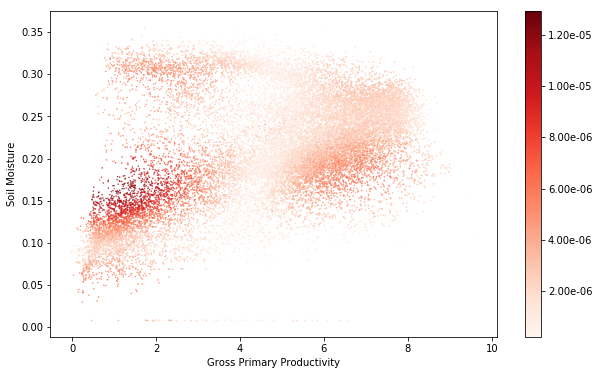

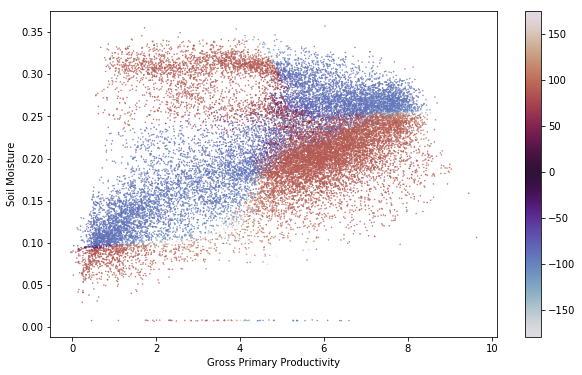

In [167]:
fig, ax = plt.subplots(figsize=(10, 6))

p = ax.scatter(X.mean(axis=1), Y.mean(axis=1), c=mod_sens['rhsic'], cmap=plt.cm.get_cmap('Reds'), s=0.2)
plt.colorbar(p, label='', format='%.2e')
ax.set_xlabel('Gross Primary Productivity')
ax.set_ylabel("Soil Moisture")
save_plt_name = f'rhsic_scatter_mod_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))

p = ax.scatter(X.mean(axis=1), Y.mean(axis=1), c=ang_sens['rhsic'], cmap=plt.cm.get_cmap('twilight'), s=0.2)
plt.colorbar(p)
ax.set_xlabel('Gross Primary Productivity')
ax.set_ylabel("Soil Moisture")
save_plt_name = f'rhsic_scatter_angle_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()

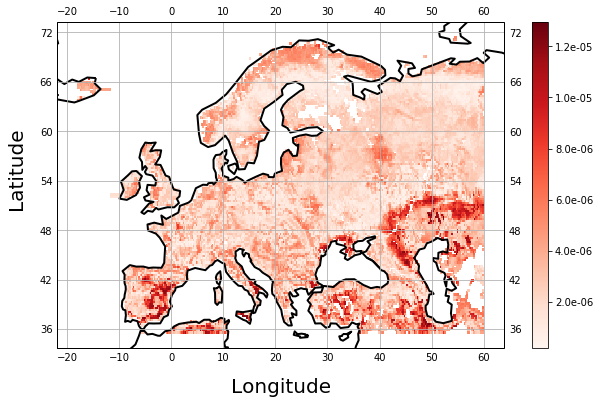

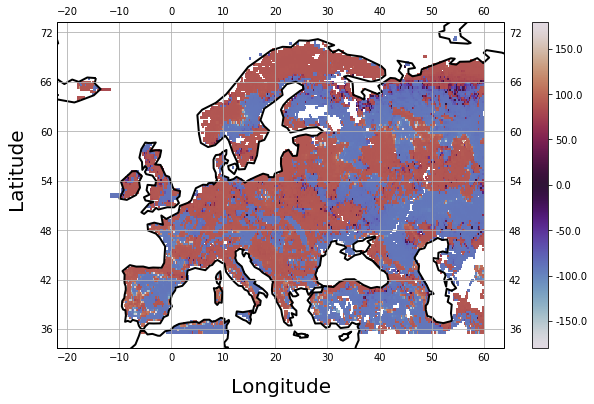

In [168]:
vis_df = pd.DataFrame({
    'lat': lat,
    'lon': lon,
    'sens': mod_sens['rhsic']
})

vis_xr = create_xarray(vis_df, variable='sens')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
p = vis_xr['sens'].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='Reds', robust=False,
    cbar_kwargs={'label': '', 
                 'format': '%.1e'}
)

ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
save_plt_name = f'rhsic_mod_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()


vis_df = pd.DataFrame({
    'lat': lat,
    'lon': lon,
    'sens': ang_sens['rhsic'],
})

# def create_xarray(xr_df, variable='gross_primary_productivity'):
    
#     xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
#     return xr_df.to_xarray()

vis_xr = create_xarray(vis_df, variable='sens')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

p = vis_xr['sens'].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='twilight', robust=False,
    cbar_kwargs={'label': '', 
                 'format': '%.1f'}
)

ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
save_plt_name = f'rhsic_angle_{year}'
plt.savefig(figures_path + save_plt_name + '.png', transparent=True)
plt.show()